In [28]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from itertools import cycle, permutations, combinations, product


from potential import MPF

import numpy as np

In [54]:
iris_ds = datasets.load_iris()

X = iris_ds.data
y = iris_ds.target
f_names = iris_ds.feature_names

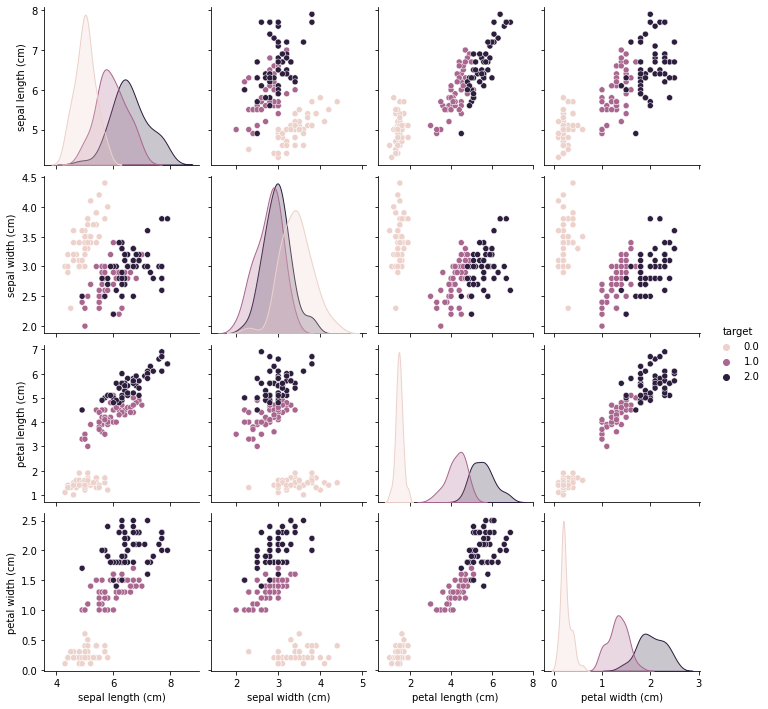

In [51]:
iris = pd.DataFrame(data= np.c_[iris_ds['data'], iris_ds['target']],
                     columns= iris_ds['feature_names'] + ['target'])
g = sns.pairplot(iris,hue='target')

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=14)

In [30]:
H = [3.0, 5.0, 7.0, 10.0]
P = [2, 1, 3, 4]
K = ["gauss", "triangular", "epanechnikov", "quadratic"]

HP = product(*(K, P, H))

kf = KFold(n_splits=5)

score = 0
best_model = None
for (k, p, h) in HP:
    mpf = MPF(kernel=k, p=p, H=h)
    for train_index, test_index in kf.split(X_train):
        mpf.fit(X_train[train_index], y_train[train_index])
        predicted = mpf.predict(X_train[test_index])
        new_score = metrics.accuracy_score(predicted, y_train[test_index])
        if abs(new_score - score) > 1e-8:
            score = new_score
            best_model = mpf

In [31]:
best_model.kernel

<function potential.quadratic(dist)>

In [32]:
best_model.p

2

In [33]:
best_model.H

10.0

In [61]:
mpf = MPF(H=5)

mpf.fit(X_train, y_train)

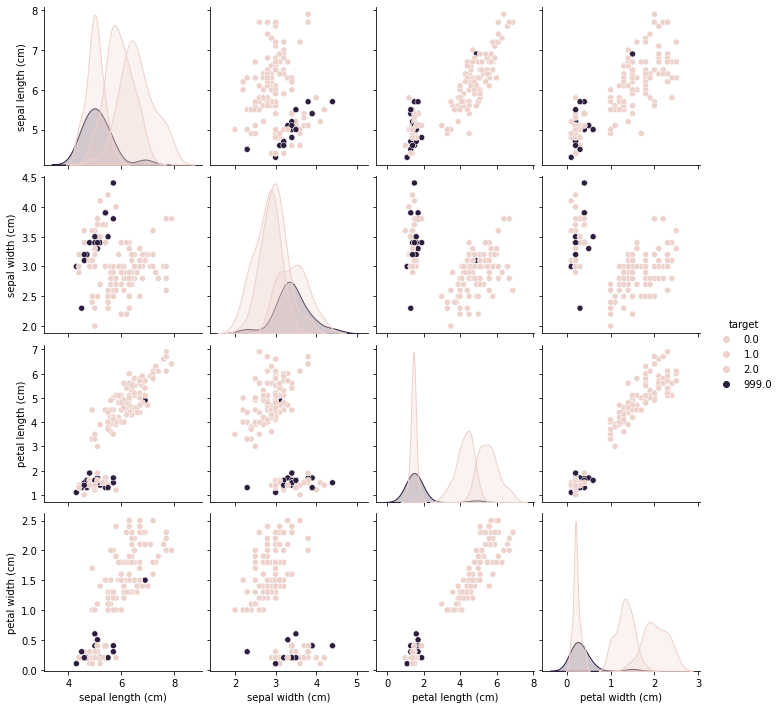

In [62]:
nz = mpf.nonzero_indexes

sns.color_palette("hls", 8)
iris_ds['target'][nz] = 999
iris_cor = pd.DataFrame(data= np.c_[iris_ds['data'], iris_ds['target']],
                     columns= iris_ds['feature_names'] + ['target'])
g = sns.pairplot(iris_cor,hue='target')

## Микро и Макро-усреднения

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [4]:
classifier = MPF()

In [5]:
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)

In [6]:
y_score.shape

(3, 75)

In [35]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = len(np.unique(y_test))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[i, :])
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], np.linspace(0, 1, y_test_bin[:, i].size))
    roc_auc[i] = auc(fpr[i], tpr[i])

In [36]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

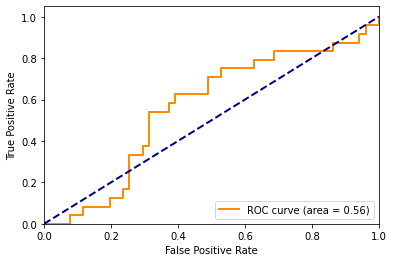

In [37]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [38]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

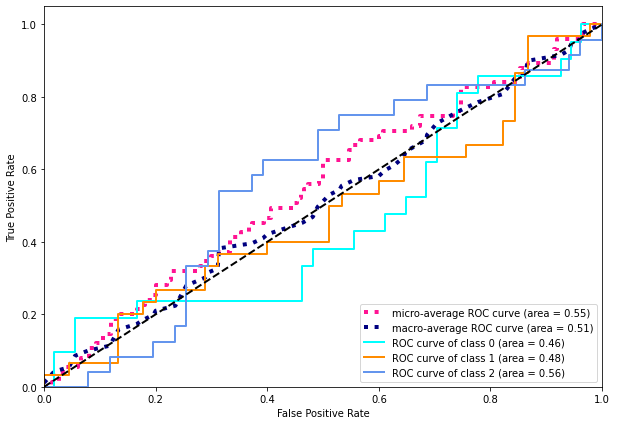

In [39]:
# Plot all ROC curves
plt.figure(figsize=(10, 7))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()